# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [13]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [14]:
bulkPath = '../nf_output_T4/countData/countData.tsv'
metaPath = '../Guegler_T4_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output_T4/alignments/dualGenome.gff3' # output from nf pipeline

In [15]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
df_initial = df_initial.drop(columns=['SRR13084797_sorted.bam', 'SRR13084807_sorted.bam', 'SRR13084811_sorted.bam', 
                                      'SRR13084799_sorted.bam', 'SRR13084810_sorted.bam', 'SRR13084796_sorted.bam', 
                                      'SRR13084795_sorted.bam', 'SRR13084798_sorted.bam', 'SRR13084809_sorted.bam', 
                                      'SRR13084794_sorted.bam', 'SRR13084808_sorted.bam', 'SRR13084806_sorted.bam'])
metadata = pd.read_csv(metaPath)
metadata = metadata[metadata['plasmid'] == 'pBR322 empty vector']

In [16]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR13084800_sorted.bam,SRR13084802_sorted.bam,SRR13084812_sorted.bam,SRR13084801_sorted.bam,SRR13084804_sorted.bam,SRR13084805_sorted.bam,SRR13084813_sorted.bam,SRR13084814_sorted.bam,SRR13084815_sorted.bam,SRR13084793_sorted.bam,SRR13084803_sorted.bam,SRR13084816_sorted.bam
Geneid,,,,,,,,,,,,,,,,,
gene-b0001,U00096.3,190,255,+,66,4119,1995,669,2190,220,277,410,178,54,21,479,44
gene-b0002,U00096.3,337,2799,+,2463,6260,2005,4178,12170,499,250,5304,2867,745,361,683,414
gene-b0003,U00096.3,2801,3733,+,933,2668,1609,1766,6018,318,127,2378,1737,448,170,410,170
gene-b0004,U00096.3,3734,5020,+,1287,3273,1672,2346,6931,278,114,3106,2414,599,234,370,283
gene-b0005,U00096.3,5234,5530,+,297,246,244,59,381,76,27,123,97,36,9,115,20


In [17]:
pd.set_option('display.max_columns', None)  # Show all columns
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,ercc_standard,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,phage,plasmid,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,substrain,time_post-infection
0,SRR13084793,RNA-Seq,69,2199397908,PRJNA679481,SAMN16834536,861930804,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",No,SRX9531474,GSM4914560,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:27:00Z,1,GSM4914560,Bacterial liquid culture,SRP293242,K-12,MG1655,30.0
7,SRR13084800,RNA-Seq,69,1466546976,PRJNA679481,SAMN16834529,568711986,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531481,GSM4914567,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:25:00Z,1,GSM4914567,Bacterial liquid culture,SRP293242,K-12,MG1655,0.0
8,SRR13084801,RNA-Seq,69,3568144974,PRJNA679481,SAMN16834490,1374694399,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531482,GSM4914568,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:31:00Z,1,GSM4914568,Bacterial liquid culture,SRP293242,K-12,MG1655,2.5
9,SRR13084802,RNA-Seq,69,2945311437,PRJNA679481,SAMN16834489,1126997448,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531483,GSM4914569,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM4914569,Bacterial liquid culture,SRP293242,K-12,MG1655,5.0
10,SRR13084803,RNA-Seq,69,3028203621,PRJNA679481,SAMN16834488,1149862790,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531484,GSM4914570,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:28:00Z,1,GSM4914570,Bacterial liquid culture,SRP293242,K-12,MG1655,10.0
11,SRR13084804,RNA-Seq,69,2837063616,PRJNA679481,SAMN16834487,1074953758,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531485,GSM4914571,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM4914571,Bacterial liquid culture,SRP293242,K-12,MG1655,20.0
12,SRR13084805,RNA-Seq,69,1850468979,PRJNA679481,SAMN16834486,701196964,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531486,GSM4914572,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:26:00Z,1,GSM4914572,Bacterial liquid culture,SRP293242,K-12,MG1655,30.0
19,SRR13084812,RNA-Seq,69,2433811263,PRJNA679481,SAMN16834514,948711039,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",No,SRX9531469,GSM4914555,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM4914555,Bacterial liquid culture,SRP293242,K-12,MG1655,0.0
20,SRR13084813,RNA-Seq,69,2278917786,PRJNA679481,SAMN16834513,893896352,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",No,SRX9531470,GSM4914556,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [18]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM4914555': '0_R1', 'GSM4914556': '2.5_R1', 'GSM4914557': '5_R1',
              'GSM4914558': '10_R1', 'GSM4914559': '20_R1', 'GSM4914560': '30_R1',
              'GSM4914567': '0_R2', 'GSM4914568': '2.5_R2', 'GSM4914569': '5_R2',
              'GSM4914570': '10_R2', 'GSM4914571': '20_R2', 'GSM4914572': '30_R2',
}

In [19]:
metadataFull = annotateData(metadata, sampleDict)

In [20]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,ercc_standard,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,phage,plasmid,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,substrain,time_post-infection
0,SRR13084793,RNA-Seq,69,2199397908,PRJNA679481,SAMN16834536,861930804,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",No,SRX9531474,GSM4914560,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:27:00Z,1,GSM4914560,Bacterial liquid culture,SRP293242,K-12,MG1655,30.0


In [21]:
metadataFull.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,ercc_standard,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,phage,plasmid,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,substrain,time_post-infection,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR13084793_sorted.bam,SRR13084793,RNA-Seq,69,2199397908,PRJNA679481,SAMN16834536,861930804,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",No,SRX9531474,GSM4914560,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T4,pBR322 empty vector,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:27:00Z,1,GSM4914560,Bacterial liquid culture,SRP293242,K-12,MG1655,30.0,SRR13084793_sorted.bam,30_R1


Add correct sample names.

In [22]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '2.5_R1', '2.5_R2', '5_R1', '5_R2', '10_R1', '10_R2', '20_R1', '20_R2', '30_R1', '30_R2']]
df

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2
Geneid,,,,,,,,,,,,
gene-b0001,669,4119,410,2190,178,1995,54,479,44,220,21,277
gene-b0002,4178,6260,5304,12170,2867,2005,745,683,414,499,361,250
gene-b0003,1766,2668,2378,6018,1737,1609,448,410,170,318,170,127
gene-b0004,2346,3273,3106,6931,2414,1672,599,370,283,278,234,114
gene-b0005,59,246,123,381,97,244,36,115,20,76,9,27
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-T4p274,0,1,1171,43209,2948,103728,230,46202,341,8491,52,7103
gene-T4p275,0,1,1307,25787,3029,60270,195,25172,369,5905,45,5612
gene-T4p276,4,0,13,765,649,82234,7845,245311,7595,46342,524,13469


### 2.2 Remove rRNA genes

2.1 Process gff3 files for front end processing

In [23]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [24]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_000866.4_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_000866.4"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
4506,NC_000866.4,RefSeq,gene,12.0,2189.0,.,-,.,gene-T4p001,rIIA,Gene,protein_coding,T4p001,rIIA,RIIA lysis inhibitor,RIIA lysis inhibitor,612,lysis
4507,NC_000866.4,RefSeq,gene,2200.0,2403.0,.,-,.,gene-T4p002,rIIA.1,Gene,protein_coding,T4p002,rIIA.1,rIIA.1 hypothetical protein,hypothetical protein,1683,unknown function
4508,NC_000866.4,RefSeq,gene,2458.0,2990.0,.,-,.,gene-T4p003,60,Gene,protein_coding,T4p003,60,DNA topoisomerase II,DNA topoisomerase II,7229,"DNA, RNA and nucleotide metabolism"
4509,NC_000866.4,RefSeq,gene,2971.0,3351.0,.,-,.,gene-T4p004,60.1,Gene,protein_coding,T4p004,60.1,gp60.1 hypothetical protein,hypothetical protein,No_PHROG,unknown function
4510,NC_000866.4,RefSeq,gene,3654.0,3767.0,.,-,.,gene-T4p005,mobA,Gene,protein_coding,T4p005,mobA,homing endonuclease,homing endonuclease,655,"DNA, RNA and nucleotide metabolism"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4789,NC_000866.4,RefSeq,gene,166815.0,166913.0,.,-,.,gene-T4p274,ndd.5,Gene,protein_coding,T4p274,ndd.5,outer membrane protein,outer membrane protein,5011,other
4790,NC_000866.4,RefSeq,gene,166910.0,166996.0,.,-,.,gene-T4p275,ndd.6,Gene,protein_coding,T4p275,ndd.6,outer membrane protein,outer membrane protein,8851,other
4791,NC_000866.4,RefSeq,gene,167103.0,167660.0,.,-,.,gene-T4p276,denB,Gene,protein_coding,T4p276,denB,DenB-like DNA endonuclease IV,DenB-like DNA endonuclease IV,1360,"DNA, RNA and nucleotide metabolism"
4792,NC_000866.4,RefSeq,gene,167743.0,167937.0,.,-,.,gene-T4p277,denB.1,Gene,protein_coding,T4p277,denB.1,DenB.1 hypothetical protein,hypothetical protein,774,unknown function


2.2 Consult gff3 file to get rRNA geneids.

In [25]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NC_000866.4', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [26]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2
Geneid,,,,,,,,,,,,
gene-b3967,170,1606,252,1340,96,427,47,198,29,162,24,53
gene-T4p149,0,0,3,744,7,2012,57,5878,2296,38749,1673,32676
gene-b2180,103,1422,391,1690,180,537,81,275,37,206,21,122
gene-b1573,9,47,12,46,2,63,5,19,1,21,0,7
gene-b1619,89,263,73,446,35,162,10,81,8,65,9,25
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1007,54,93,50,320,42,103,5,65,8,43,4,20
gene-b0793,49,238,64,529,26,261,9,188,5,116,5,34
gene-b1976,56,281,42,224,24,124,2,66,7,50,7,32


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [27]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [28]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b3967,25.720854,45.564027,25.704795,17.691099,9.219858,4.756533,5.993126,2.735519,2.575181,1.835062,6.925588,0.837717,host,murI
gene-T4p149,0.378462,0.071155,1.787771,49.299656,3.595418,112.352167,36.401463,406.477933,1005.873545,2195.607417,2373.599509,2567.261826,phage,5.3
gene-b2180,8.425419,21.771272,21.506745,12.039081,9.306027,3.227179,5.548909,2.048760,1.766474,1.258368,3.279587,1.035070,host,yejF
gene-b1573,5.614716,5.278107,4.985468,2.404275,0.935794,2.768033,2.718728,1.052827,0.513003,0.951216,0.553737,0.460095,host,ydfC
gene-b1619,15.083777,8.349261,8.359228,6.583177,3.789233,2.019918,1.480046,1.254767,0.828955,0.826351,3.000131,0.446077,host,hdhA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1007,14.250811,4.596583,8.910996,7.331589,7.038303,1.996075,1.202831,1.564598,1.286136,0.851469,2.204881,0.556390,host,rutF
gene-b0793,5.649896,5.118044,4.968059,5.287230,1.915654,2.201407,0.906896,1.965463,0.363264,0.995400,1.176325,0.408730,host,ybhS
gene-b1976,9.164185,8.584286,4.651854,3.185582,2.516792,1.489389,0.339144,0.985338,0.703933,0.613159,2.279482,0.547156,host,mtfA


In [29]:
# Check gene names unique
len(tpms['Symbol'].unique())

4772

Log2+1 normalization raw counts

In [30]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b3967,7.417853,10.650154,7.982994,10.389094,6.599913,8.741467,5.584963,7.636625,4.906891,7.348728,4.643856,5.754888,host,murI
gene-T4p149,0.000000,0.000000,2.000000,9.541097,3.000000,10.975131,5.857981,12.521355,11.165535,15.241909,10.709084,14.995988,phage,5.3
gene-b2180,6.700440,10.474720,8.614710,10.723661,7.499846,9.071462,6.357552,8.108524,5.247928,7.693487,4.459432,6.942515,host,yejF
gene-b1573,3.321928,5.584963,3.700440,5.554589,1.584963,6.000000,2.584963,4.321928,1.000000,4.459432,0.000000,3.000000,host,ydfC
gene-b1619,6.491853,8.044394,6.209453,8.804131,5.169925,7.348728,3.459432,6.357552,3.169925,6.044394,3.321928,4.700440,host,hdhA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1007,5.781360,6.554589,5.672425,8.326429,5.426265,6.700440,2.584963,6.044394,3.169925,5.459432,2.321928,4.392317,host,rutF
gene-b0793,5.643856,7.900867,6.022368,9.049849,4.754888,8.033423,3.321928,7.562242,2.584963,6.870365,2.584963,5.129283,host,ybhS
gene-b1976,5.832890,8.139551,5.426265,7.813781,4.643856,6.965784,1.584963,6.066089,3.000000,5.672425,3.000000,5.044394,host,mtfA


Log2+1 normalization tpms

In [31]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b3967,4.739894,5.541144,4.739027,4.224280,3.353303,2.525200,2.805938,1.901309,1.838016,1.503380,2.986518,0.877914,host,murI
gene-T4p149,0.463059,0.099167,1.479112,5.652477,2.200196,6.824668,5.225023,8.670578,9.975667,11.101061,11.213468,11.326577,phage,5.3
gene-b2180,3.236557,4.509143,4.492286,3.704770,3.365416,2.079695,2.711255,1.608222,1.468048,1.175281,2.097472,1.025078,host,yejF
gene-b1573,2.725679,2.650330,2.581464,1.767348,0.952925,1.913812,1.894809,1.037612,0.597415,0.964373,0.635743,0.546063,host,ydfC
gene-b1619,4.007534,3.224852,3.226390,2.922802,2.259795,1.594510,1.310367,1.172978,0.871019,0.868964,2.000047,0.532144,host,hdhA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1007,3.930814,2.484546,3.309030,3.058592,3.006891,1.583074,1.139359,1.358732,1.192911,0.888670,1.680271,0.638204,host,rutF
gene-b0793,2.733332,2.613070,2.577262,2.652425,1.543819,1.678706,0.931226,1.568257,0.447065,0.996678,1.121894,0.494395,host,ybhS
gene-b1976,3.345423,3.260671,2.498724,2.065428,1.814260,1.315792,0.421311,0.989385,0.768869,0.689889,1.713468,0.629619,host,mtfA


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [32]:
columnOrder = ['0_R1', '0_R2', '2.5_R1', '2.5_R2', '5_R1', '5_R2', '10_R1', '10_R2', '20_R1', '20_R2', '30_R1', '30_R2']

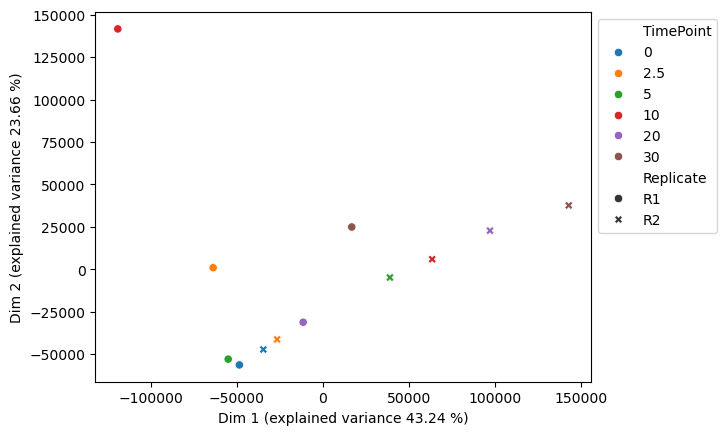

In [33]:
txPCA(tpms[columnOrder])

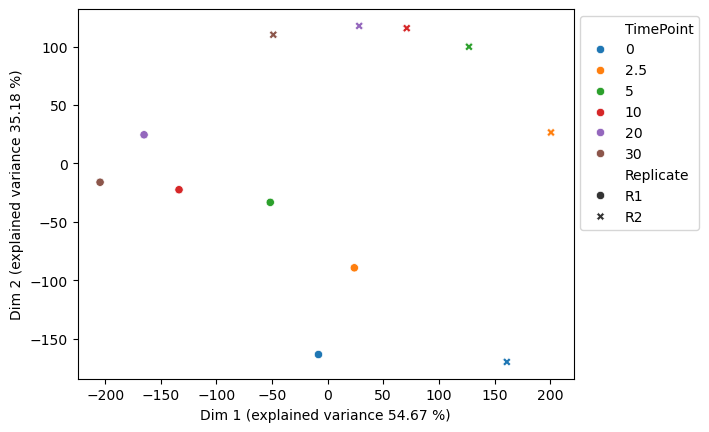

In [34]:
txPCA(logs[columnOrder])

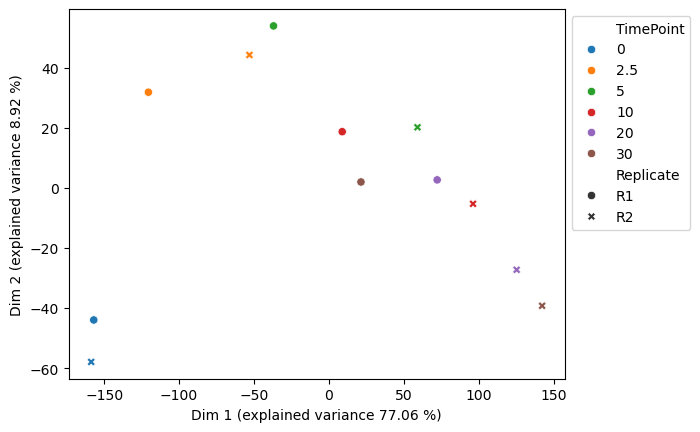

In [35]:
txPCA(logTPMs[columnOrder])

In [36]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

In [37]:
logTPMs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b3967,4.739894,5.541144,4.739027,4.224280,3.353303,2.525200,2.805938,1.901309,1.838016,1.503380,2.986518,0.877914,host,murI
gene-T4p149,0.463059,0.099167,1.479112,5.652477,2.200196,6.824668,5.225023,8.670578,9.975667,11.101061,11.213468,11.326577,phage,5.3
gene-b2180,3.236557,4.509143,4.492286,3.704770,3.365416,2.079695,2.711255,1.608222,1.468048,1.175281,2.097472,1.025078,host,yejF
gene-b1573,2.725679,2.650330,2.581464,1.767348,0.952925,1.913812,1.894809,1.037612,0.597415,0.964373,0.635743,0.546063,host,ydfC
gene-b1619,4.007534,3.224852,3.226390,2.922802,2.259795,1.594510,1.310367,1.172978,0.871019,0.868964,2.000047,0.532144,host,hdhA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1007,3.930814,2.484546,3.309030,3.058592,3.006891,1.583074,1.139359,1.358732,1.192911,0.888670,1.680271,0.638204,host,rutF
gene-b0793,2.733332,2.613070,2.577262,2.652425,1.543819,1.678706,0.931226,1.568257,0.447065,0.996678,1.121894,0.494395,host,ybhS
gene-b1976,3.345423,3.260671,2.498724,2.065428,1.814260,1.315792,0.421311,0.989385,0.768869,0.689889,1.713468,0.629619,host,mtfA


tpmHost

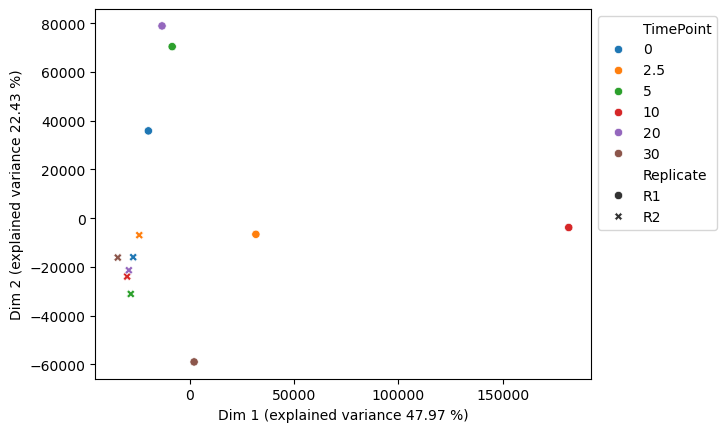

In [38]:
txPCA(tpmHost[columnOrder])

tpmPhage

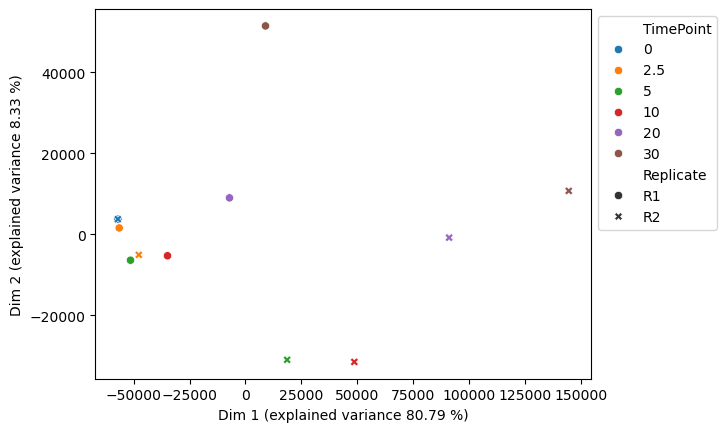

In [39]:
txPCA(tpmPhage[columnOrder])

logTPM Host

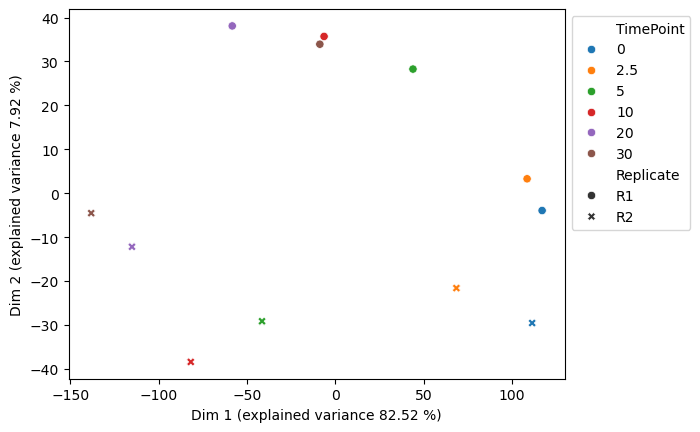

In [40]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

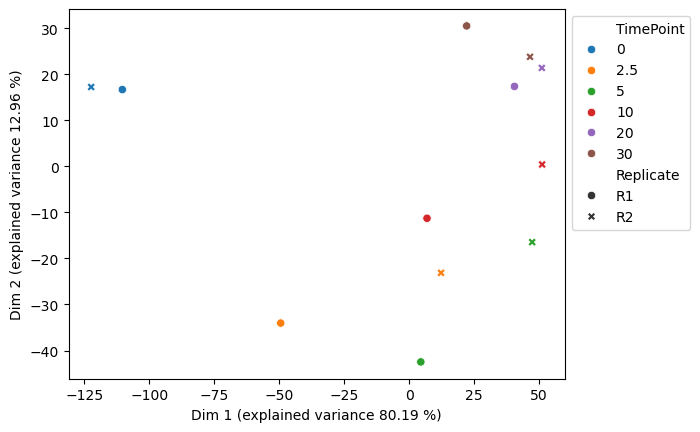

In [41]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Replicates seem to be fine (not perfect, but no clear outliers detectable)

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [42]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '2.5', '5', '10', '20', '30']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,2.5,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,
gene-b3967,35.642440,21.697947,6.988195,4.364323,2.205122,3.881652,host,murI
gene-T4p149,0.224808,25.543714,57.973792,221.439698,1600.740481,2470.430667,phage,5.3
gene-b2180,15.098346,16.772913,6.266603,3.798834,1.512421,2.157329,host,yejF
gene-b1573,5.446411,3.694872,1.851913,1.885777,0.732110,0.506916,host,ydfC
gene-b1619,11.716519,7.471203,2.904576,1.367406,0.827653,1.723104,host,hdhA
...,...,...,...,...,...,...,...,...
gene-b1007,9.423697,8.121292,4.517189,1.383714,1.068802,1.380636,host,rutF
gene-b0793,5.383970,5.127644,2.058530,1.436180,0.679332,0.792528,host,ybhS
gene-b1976,8.874235,3.918718,2.003091,0.662241,0.658546,1.413319,host,mtfA


In [43]:
TPMsds = TPMsds[['0', '2.5', '5', '10', '20', '30']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,2.5,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,
gene-b3967,9.921586,4.006848,2.231663,1.628803,0.370059,3.043935,host,murI
gene-T4p149,0.153654,23.755942,54.378374,185.038235,594.866936,96.831159,phage,5.3
gene-b2180,6.672927,4.733832,3.039424,1.750075,0.254053,1.122259,host,yejF
gene-b1573,0.168305,1.290597,0.916120,0.832950,0.219106,0.046821,host,ydfC
gene-b1619,3.367258,0.888025,0.884657,0.112640,0.001302,1.277027,host,hdhA
...,...,...,...,...,...,...,...,...
gene-b1007,4.827114,0.789703,2.521114,0.180883,0.217333,0.824245,host,rutF
gene-b0793,0.265926,0.159586,0.142877,0.529283,0.316068,0.383798,host,ybhS
gene-b1976,0.289950,0.733136,0.513702,0.323097,0.045387,0.866163,host,mtfA


In [44]:
propExp = proportionalExp(TPMmeans[['0', '2.5', '5', '10', '20', '30']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,2.5,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,
gene-b3967,1.000000,0.608767,0.196064,0.122447,0.061868,0.108905,host,murI
gene-T4p149,0.000091,0.010340,0.023467,0.089636,0.647960,1.000000,phage,5.3
gene-b2180,0.900162,1.000000,0.373614,0.226486,0.090170,0.128620,host,yejF
gene-b1573,1.000000,0.678405,0.340025,0.346242,0.134421,0.093073,host,ydfC
gene-b1619,1.000000,0.637664,0.247904,0.116708,0.070640,0.147066,host,hdhA
...,...,...,...,...,...,...,...,...
gene-b1007,1.000000,0.861795,0.479344,0.146833,0.113416,0.146507,host,rutF
gene-b0793,1.000000,0.952391,0.382344,0.266751,0.126177,0.147201,host,ybhS
gene-b1976,1.000000,0.441584,0.225720,0.074625,0.074209,0.159261,host,mtfA


## 5. Phage gene classification

In [45]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')
        elif timePoint == 5:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [46]:
# Export fractional expressions with T=0.6 + Host/Phage Annotation for Orthofinder Analysis
# t = classLabelThreshold(propExp)
# t = t[t["Entity"] == "phage"]
# t["Host"] = "Escherichia_Coli_minusToxIN"
# t["Phage"] = "Enterobacteria_phage_T4"
# t.to_csv("/ceph/ibmi/studenten/waffen/Cross_Analysis/Orthofinder_Clustering/Fractional_Expressions/T060/Guegler_T4_minusToxIN_fractional_expression_T=0.6.tsv", sep="\t")

In [47]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')
        elif timePoint == 5:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [48]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [49]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      113
early     109
middle     66
Name: count, dtype: int64

In [50]:
t = TPMmeans[TPMmeans["Entity"] == "phage"]
t = t[["Symbol", "ClassThreshold"]]
t.columns = ["gene", "classification"]
t.to_csv("gene_classification_Guegler_2021_T4_minus_toxIN_[0.2].csv", index=False)

Add classes to other dfs.

In [51]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'U00096.3']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_000866.4']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [52]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [53]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,
gene-b3967,25.720854,45.564027,25.704795,17.691099,9.219858,4.756533,5.993126,2.735519,2.575181,1.835062,6.925588,0.837717,host,murI,None,None,13.754069
gene-T4p149,0.378462,0.071155,1.787771,49.299656,3.595418,112.352167,36.401463,406.477933,1005.873545,2195.607417,2373.599509,2567.261826,phage,5.3,late,late,1354.409076
gene-b2180,8.425419,21.771272,21.506745,12.039081,9.306027,3.227179,5.548909,2.048760,1.766474,1.258368,3.279587,1.035070,host,yejF,None,None,6.662164
gene-b1573,5.614716,5.278107,4.985468,2.404275,0.935794,2.768033,2.718728,1.052827,0.513003,0.951216,0.553737,0.460095,host,ydfC,None,None,1.498212
gene-b1619,15.083777,8.349261,8.359228,6.583177,3.789233,2.019918,1.480046,1.254767,0.828955,0.826351,3.000131,0.446077,host,hdhA,None,None,4.184929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1007,14.250811,4.596583,8.910996,7.331589,7.038303,1.996075,1.202831,1.564598,1.286136,0.851469,2.204881,0.556390,host,rutF,None,None,3.838849
gene-b0793,5.649896,5.118044,4.968059,5.287230,1.915654,2.201407,0.906896,1.965463,0.363264,0.995400,1.176325,0.408730,host,ybhS,None,None,1.510806
gene-b1976,9.164185,8.584286,4.651854,3.185582,2.516792,1.489389,0.339144,0.985338,0.703933,0.613159,2.279482,0.547156,host,mtfA,None,None,2.938648


In [54]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [55]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]

In [56]:
# Full TPM table
tpms.to_csv('Guegler_T4_minusToxIN_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Guegler_T4_minusToxIN_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Guegler_T4_minusToxIN_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Guegler_T4_minusToxIN_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Guegler_T4_minusToxIN_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Guegler_T4_minusToxIN_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Guegler_T4_minusToxIN_phage_gff3.tsv', sep='\t')